In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from skimage.io import imread
import cv2
import warnings
import os
import keras
warnings.filterwarnings(action='once')

Using TensorFlow backend.


In [2]:
#https://pypi.org/project/keras-adabound/
#https://segmentation-models.readthedocs.io/en/latest/
!pip install keras-adabound
!pip install segmentation-models

  Stored in directory: /tmp/.cache/pip/wheels/26/fb/78/f6aa020cb8f098fecdf1e9043a9bb259c8414692d4225c6183
Successfully built keras-adabound
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 51kB 3.4MB/s 
    100% |████████████████████████████████| 81kB 10.2MB/s 
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Data Processing

In [3]:
train_path = '../input/train_v2/'
test_path = '../input/test_v2/'
data = pd.read_csv('../input/train_ship_segmentations_v2.csv')

In [4]:
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries

from skimage.morphology import binary_opening, disk, label
import gc
gc.enable() 

train_image_dir = train_path
test_image_dir = test_path

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    if type(in_mask_list) == 'float':
        return all_masks
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Data Generator**

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

(119839, 3)


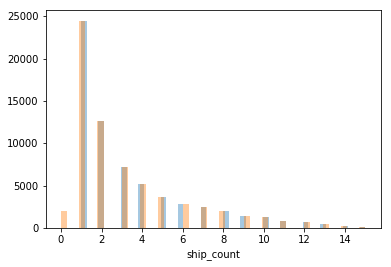

In [5]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
val = data[~msk]

train_no_ship = train[train["EncodedPixels"].isnull()]
train_with_ship = train[train["EncodedPixels"].notnull()]
train_with_ship['ship_count'] = train_with_ship.groupby('ImageId')['ImageId'].transform('count')
train_with_ship['ship_count'].fillna(0,inplace=True) 
train_no_ship['ship_count'] = 0
print(train_no_ship.shape)
sns.distplot(train_with_ship['ship_count'],kde=False);

down_sampled_no_ship = train_no_ship.sample(2000)
balanced_train = pd.concat([down_sampled_no_ship, train_with_ship])
#balanced_train = train_with_ship
sns.distplot(balanced_train['ship_count'],kde=False);

In [6]:
partition = {}
partition['train'] = balanced_train['ImageId'].values
partition['val'] = val['ImageId'].values

In [7]:
from skimage.transform import rotate
from skimage import exposure

def transform(image, mask, rate=0.15):
    rnd = np.random.uniform(0, 1, 5)
    ## contrast
    if rnd[2] < rate:
        v_min, v_max = np.percentile(image, (0.2, 99.8))
        image= exposure.rescale_intensity(image, in_range=(v_min, v_max))
        
    ## horizontal flip
    if rnd[3] < rate:
        image= image[:, ::-1]
        mask = mask[:, ::-1]
    
    ## vertical flip
    if rnd[4] < rate:
        image= image[::-1, :]
        mask = mask[::-1, :]
        

    """
    ## rotation
    if rnd[0] < rate:
        deg = np.random.choice(range(6, 25))
        image= rotate(image, deg)
    """

    

    return image, mask

def rotation(image):
    deg = np.random.choice(range(6, 25))
    image= rotate(image, deg)
    return image

In [8]:
from keras.utils import Sequence
import gc

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, data, batch_size=5, dim=(512, 512, 3), shuffle=True, resize_img = False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.resize = resize_img
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        gc.collect()

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path = os.path.join(train_path, ID)
            image = imread(path)
            encoded_pixels = self.data[self.data['ImageId']==ID]['EncodedPixels']
            mask = masks_as_image(encoded_pixels)
            if self.resize:
                resized_x = cv2.resize(image, (self.dim[0], self.dim[1]))
                resized_y = cv2.resize(mask, (self.dim[0], self.dim[1]))
                reshaped_y = np.reshape(resized_y, (self.dim[0], self.dim[1], 1))
                tx, y[i] = transform(resized_x, reshaped_y)
                X[i,] = tx/255.0
                
            else:
                reshaped_y = np.reshape(mask, (self.dim[0], self.dim[1], 1))
                tx, y[i] = transform(image, reshaped_y)
                X[i,] = tx/255.0

        return X, y

In [9]:
partition['train'].shape, partition['val'].shape
# partition['reduced_train'] = np.random.choice(partition['train'], 8000)
# partition['reduced_val'] = np.random.choice(partition['val'], 1000)

((67322,), (46562,))

In [10]:
# Parameters

params = {'dim': (512, 512, 3),
          'batch_size': 16,
          'shuffle': True, 
         'resize_img':True}
"""


params = {'dim': (768, 512, 3),
          'batch_size': 1,
          'shuffle': True}
"""
# Generators

train_gen = DataGenerator(partition['train'], data, **params)
val_gen = DataGenerator(partition['val'], data, **params)

In [11]:
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.callbacks import ModelCheckpoint ,ReduceLROnPlateau

BATCH_SIZE = params['batch_size']
steps_per_epoch = partition['train'].shape[0]//BATCH_SIZE
validation_steps = partition['val'].shape[0]//BATCH_SIZE

def f2_micro(y_true, y_pred):
    agreement = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_true_positive = K.sum(K.round(K.clip(y_true, 0, 1)))
    total_pred_positive = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = agreement / (total_true_positive + K.epsilon())
    precision = agreement / (total_pred_positive + K.epsilon())
    return (1+2**2)*((precision*recall)/(2**2*precision+recall+K.epsilon()))

checkpointer = ModelCheckpoint(filepath='unet3.hdf5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)

In [12]:
# from https://www.kaggle.com/danmoller/make-best-use-of-a-kernel-s-limited-uptime-keras
import time 

#let's also import the abstract base class for our callback
from keras.callbacks import Callback

#defining the callback
class TimerCallback(Callback):
    
    def __init__(self, maxExecutionTime, byBatch = False, on_interrupt=None):
        
# Arguments:
#     maxExecutionTime (number): Time in minutes. The model will keep training 
#                                until shortly before this limit
#                                (If you need safety, provide a time with a certain tolerance)

#     byBatch (boolean)     : If True, will try to interrupt training at the end of each batch
#                             If False, will try to interrupt the model at the end of each epoch    
#                            (use `byBatch = True` only if each epoch is going to take hours)          

#     on_interrupt (method)          : called when training is interrupted
#         signature: func(model,elapsedTime), where...
#               model: the model being trained
#               elapsedTime: the time passed since the beginning until interruption   

        
        self.maxExecutionTime = maxExecutionTime * 60
        self.on_interrupt = on_interrupt
        
        #the same handler is used for checking each batch or each epoch
        if byBatch == True:
            #on_batch_end is called by keras every time a batch finishes
            self.on_batch_end = self.on_end_handler
        else:
            #on_epoch_end is called by keras every time an epoch finishes
            self.on_epoch_end = self.on_end_handler
    
    
    #Keras will call this when training begins
    def on_train_begin(self, logs):
        self.startTime = time.time()
        self.longestTime = 0            #time taken by the longest epoch or batch
        self.lastTime = self.startTime  #time when the last trained epoch or batch was finished
    
    
    #this is our custom handler that will be used in place of the keras methods:
        #`on_batch_end(batch,logs)` or `on_epoch_end(epoch,logs)`
    def on_end_handler(self, index, logs):
        
        currentTime      = time.time()                           
        self.elapsedTime = currentTime - self.startTime    #total time taken until now
        thisTime         = currentTime - self.lastTime     #time taken for the current epoch
                                                               #or batch to finish
        
        self.lastTime = currentTime
        
        #verifications will be made based on the longest epoch or batch
        if thisTime > self.longestTime:
            self.longestTime = thisTime
        
        
        #if the (assumed) time taken by the next epoch or batch is greater than the
            #remaining time, stop training
        remainingTime = self.maxExecutionTime - self.elapsedTime
        if remainingTime < self.longestTime:
            
            self.model.stop_training = True  #this tells Keras to not continue training
            print("\n\nTimerCallback: Finishing model training before it takes too much time. (Elapsed time: " + str(self.elapsedTime/60.) + " minutes )\n\n")
            
            #if we have passed the `on_interrupt` callback, call it here
            if self.on_interrupt is not None:
                self.on_interrupt(self.model, self.elapsedTime)

## Model

In [13]:
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.callbacks import ModelCheckpoint , ReduceLROnPlateau, History
import json
import matplotlib.pyplot as plt

def f2_micro(y_true, y_pred):
    agreement = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_true_positive = K.sum(K.round(K.clip(y_true, 0, 1)))
    total_pred_positive = K.sum(K.round(K.clip(y_pred, 0, 1)))
    recall = agreement / (total_true_positive + K.epsilon())
    precision = agreement / (total_pred_positive + K.epsilon())
    return (1+2**2)*((precision*recall)/(2**2*precision+recall+K.epsilon()))

checkpointer = ModelCheckpoint(filepath='unet3.5.hdf5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)

hist = History()

def default(obj):
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))
    
def saveWeights(model, elapsed=None):
    model.save('unet3.5.hdf5')
    json.dump(hist.history, open("hist_dict.json", 'w'), default=default)
    plt.plot(hist.history["loss"],label="training loss")
    plt.plot(hist.history["val_loss"],label="val loss")
    plt.title("UNet 3.5 Loss")
    plt.legend()
    plt.show()

tc = TimerCallback(510, on_interrupt=saveWeights)

In [14]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable
from segmentation_models.losses import dice_loss
from keras_adabound import AdaBound

model = Unet(encoder_weights=None,encoder_freeze=False)
model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1), loss=dice_loss, metrics=[f2_micro])

model.fit_generator(generator=train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=4,
                    pickle_safe=False,
                    callbacks=[checkpointer, reduce_lr, hist, tc],
                    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '
/opt/conda/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<__main__...., validation_data=<__main__...., steps_per_epoch=4207, validation_steps=2910, epochs=4, callbacks=[<keras.ca..., verbose=1, use_multiprocessing=False)`
  app.launch_new_instance()


Epoch 1/4
4207/4207 [==============================] - 6630s 2s/step - loss: 0.5857 - f2_micro: 0.4453 - val_loss: 0.8174 - val_f2_micro: 0.5504

Epoch 00001: val_loss improved from inf to 0.81743, saving model to unet3.5.hdf5
Epoch 2/4
1216/4207 [=======>......................] - ETA: 49:07 - loss: 0.4969 - f2_micro: 0.6087